In [1]:
using Pkg: @pkg_str
pkg"activate  ."

![](https://white.ucc.asn.au/posts_assets/Intro%20to%20Machine%20Learning%20with%20TensorFlow.jl_files/Intro%20to%20Machine%20Learning%20with%20TensorFlow.jl_28_0.png)



In [3]:
using MLDatasets
using Plots
using MLDataUtils
using Statistics

using TensorFlow

## Network Definition

In [4]:
sess = Session(Graph())

leaky_relu6(x) = 0.01x + nn.relu6(x)

# Network Definition
@tf begin
    X = placeholder(Float32, shape=[-1, 28*28])
    
    # Network parameters
    hl_sizes = [512, 128, 64, 2, 64, 128, 512]

    Zs = [X]
    for (ii, hlsize) in enumerate(hl_sizes)
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = leaky_relu6(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
    
    Wout = get_variable([get_shape(Zs[end], 2), 28*28], Float32)
    bout = get_variable([28*28], Float32)
    Y = nn.sigmoid(Zs[end]*Wout + bout)
    
    
    Z_code = Zs[end÷2 + 1] # A name for the coding layer
    @assert get_shape(Z_code,2) == 2
end

losses = 0.5(Y .- X).^2
loss = reduce_mean(losses) + 0.01reduce_mean(bout.^2)
optimizer = train.minimize(train.AdamOptimizer(), loss)

2019-02-13 18:11:00.662337: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


<Tensor Group:1 shape=() dtype=Any>

## Visualisation Code

In [5]:

function one_image(img::Vector, frames_image_res=30)
    ret = zeros((frames_image_res, frames_image_res))
    ret[2:end-1, 2:end-1] = 1 .- rotl90(reshape(img, (28,28)))
    ret
end

function scatter_image(images, res; frames_image_res=30, no_overlap=false)
    canvas = ones(res, res)
    images = reshape(images, (28*28, :));
    codes = run(sess, Z_code, Dict(X=>images'))
    for ii in 1:2
        codes[:,ii] = (codes[:,ii] .- minimum(codes[:,ii]))./(maximum(codes[:,ii])-minimum(codes[:,ii]))
        @assert(minimum(codes[:,ii]) >= 0.0)
        @assert(maximum(codes[:,ii]) <= 1.0)
    end
    
    function target_area(code)
        central_res = res-frames_image_res-1
        border_offset = frames_image_res/2 + 1
        x,y = code*central_res .+ border_offset
        
        get_pos(v) = round(Int, v-frames_image_res/2)
        x_min = get_pos(x)
        x_max = x_min + frames_image_res-1
        y_min =  get_pos(y)
        y_max = y_min + frames_image_res-1
        
        @view canvas[x_min:x_max, y_min:y_max]
    end
    
    for ii in 1:size(codes, 1)
        code = codes[ii,:]
        img = images[:,ii]
        area = target_area(code)        
        no_overlap && any(area.<1) && continue # Don't draw over anything
        area[:] = one_image(img, frames_image_res)
    end
    canvas
end


function demo_plot()
    code_plt = scatter_image(test_images[:,:,1:100], 700)

    src_images = Float32.(test_images[:,:,6:7])
    src1 = one_image(vec(src_images[:,:,1]))
    src2 = one_image(vec(src_images[:,:,2]))

    dst_vecs = run(sess, sess.graph["Y"], Dict(X=>reshape(src_images, :, 28*28)))
    
    dst1 = one_image(dst_vecs[1,:])
    dst2 = one_image(dst_vecs[2,:])

    plot(
        heatmap(code_plt),
        plot(heatmap(src1), heatmap(dst1); layout=grid(2,1)),
        plot(heatmap(src2), heatmap(dst2); layout=grid(2,1));
        axis=false, colorbar=false,
        layout=grid(1,3; widths=(0.7,0.15, 0.15))
    )
end

demo_plot (generic function with 1 method)

# Training Code

In [6]:
const train_images = MNIST.traintensor()
const test_images = MNIST.testtensor();

In [7]:
const train_images_flat = reshape(train_images, (28*28, :))'

60000×784 LinearAlgebra.Adjoint{FixedPointNumbers.Normed{UInt8,8},Base.ReshapedArray{FixedPointNumbers.Normed{UInt8,8},2,Base.ReinterpretArray{FixedPointNumbers.Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

In [8]:
run(sess, global_variables_initializer())

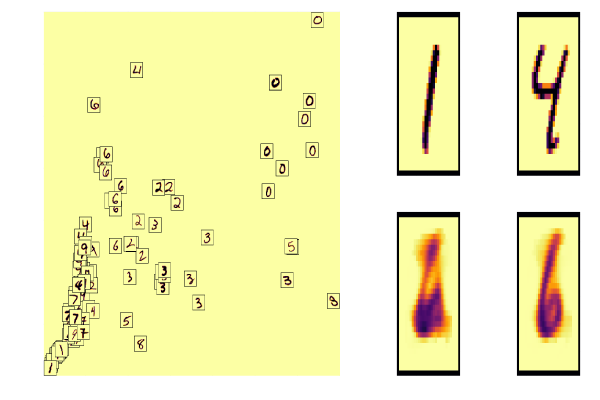

Epoch: 41, Batch 41 loss: 0.019998179672757438


In [ ]:
let 
    for epoch in 1:100
        train_obs = shuffleobs(train_images_flat, ObsDim.First())
        batches = eachbatch(train_obs, 1_000, ObsDim.First())
        for (batch_ii, batch_x) in enumerate(batches)
            loss_o, _ = run(sess, (loss, optimizer), Dict(X=>batch_x))

            if batch_ii % 10 == 1 
                println("Epoch: $epoch, Batch $batch_ii loss: $(loss_o)")
                display(demo_plot())
                IJulia.clear_output(true)
            end
        end
    end
end